# Saving and Retrieving HITS postage stamps

By: Bryce Kalmbach ([@jbkalmbach](https://github.com/jbkalmbach))

Last updated: 03/24/2020

This notebook shows how we extract postage stamps from 2015 HITS data processed with the LSST stack into warped tracts and patches using the starting pixel coordinates
and the pixel coordinate velocities.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

In [2]:
from lsst.afw import image as afwImage

## Load in HITS data and KBMOD discoveries in HITS

We stored the HITS data on `pogo4` and will save these stamps to the directory `kbmod/notebooks/hits_postage_stamps`.

In [3]:
hits_image_dir = '/astro/store/pogo4/jbkalmbach/HITS_DATA/tempExp'
hits_data_dir = 'hits_data/'

We have a pandas dataframe saved with information on all the visits we processed.

In [4]:
hits_visit_info_df = pd.read_csv(os.path.join(hits_data_dir, 'hits_visit_df.csv'), index_col=0)

In [5]:
hits_visit_info_df.head()

,visit_num,tract_id,filter,field_name,image_mjd,field,ra,dec
0,406285,12,r,Blind15A_01,57057.163410,1,09:13:31.152,-06:18:04.68
1,406287,12,r,Blind15A_01,57057.166057,1,09:13:31.152,-06:18:04.68
2,406288,13,r,Blind15A_02,57057.167334,2,09:08:53.952,-04:18:02.81
3,406289,14,r,Blind15A_03,57057.168609,3,09:13:30.840,-02:17:49.30
4,406290,15,r,Blind15A_04,57057.169878,4,09:08:53.952,-00:17:59.06


We also load in a spreadsheet we made with our discoveries. This has the starting pixel and pixel velocity information for each object.

In [6]:
hits_objects = pd.read_csv(os.path.join(hits_data_dir, 'hits_found_objects.csv'))

In [7]:
hits_objects.head()

,tract,patch_horizontal,patch_vertical,x0,y0,x_vel,y_vel,Estimated Distance (AU),Distance Error,Eccentricity,...,g_mag,Node,Found in MPChecker?,Notes,Chi Square,DOF,Reduced CS,MPC ID,Unnamed: 21,Unnamed: 22
0,0,2,4,1622,1500,214.204620,81.383980,67.33,44.44,0.42,...,23.68,224.57,No,NaN,9.73,33,0.294848,2015 DZ248,NaN,NaN
1,3,4,4,987,1135,472.435577,223.248917,21.38,2.77,0.36,...,24.14,194.53,No,NaN,11.89,32,0.371563,2015 DT248,NaN,NaN
2,5,5,3,3496,1607,216.298416,94.617867,43.67,21.99,0.20,...,23.74,194.47,No,NaN,7.78,21,0.370476,2015 DT249,NaN,NaN
3,7,4,6,1243,1021,238.136871,76.018631,48.02,29.09,0.28,...,24.19,282.11,No,NaN,16.57,21,0.789048,2015 DY248,NaN,NaN
4,7,4,6,3047,3182,226.968872,100.539658,37.61,18.18,0.02,...,24.24,170.94,No,NaN,16.51,20,0.825500,2015 DX248,NaN,NaN


## Get postage stamps for objects

Using the pixel starting location and velocities as well as the MJD for each visit we can then go in and retrieve the postage stamps we need. The first step is to set the postage stamp size. Stamps that are not a full stamp will be discarded to make saving easier. If running this notebook interactively you can comment out that line.

In [8]:
stamp_x_width = 40
stamp_y_width = 40

In [12]:
for obj_num in range(len(hits_objects)):

    obj_data_dict = {}
    
    obj_mpc_name = hits_objects.iloc[obj_num]['MPC ID']
    obj_tract = hits_objects.iloc[obj_num]['tract']
    obj_patch_h = hits_objects.iloc[obj_num]['patch_horizontal']
    obj_patch_v = hits_objects.iloc[obj_num]['patch_vertical']
    obj_starting_x = int(hits_objects.iloc[obj_num]['x0'])
    obj_starting_y = int(hits_objects.iloc[obj_num]['y0'])
    obj_vel_x = float(hits_objects.iloc[obj_num]['x_vel'])
    obj_vel_y = float(hits_objects.iloc[obj_num]['y_vel'])

    print(obj_mpc_name)
    
    # Find the visits for the correct tract
    obj_visits = hits_visit_info_df.query('tract_id == %i' % obj_tract)

    # Starting mjd is the first 'g' visit since that is where our searches start
    obj_start_mjd = obj_visits.query('image_mjd > 57069.9 and image_mjd < 57071 and filter == "g"').iloc[0]['image_mjd']
    sci_stamp_list = []
    sci_mjd_list = []
    sci_filt_list = []
    sci_visit_list = []
    sci_psf_list = []
    mask_stamp_list = []
    var_stamp_list = []
    fluxmag0_list = []

    for obj_visit_idx in range(len(obj_visits)):

        obj_visit_id = obj_visits.iloc[obj_visit_idx]['visit_num']
        obj_visit_filter = obj_visits.iloc[obj_visit_idx]['filter']
        obj_visit_mjd = obj_visits['image_mjd'].iloc[obj_visit_idx]

        # This is the format for the filename
        obj_visit_path = os.path.join(hits_image_dir, 
                                      obj_visit_filter, 
                                      '%i' % obj_tract, 
                                      '%i,%itempExp' % (obj_patch_h, obj_patch_v), 
                                      'v%i-f%s.fits' % (obj_visit_id, obj_visit_filter))

        try:
            hdulist = fits.open(obj_visit_path)
        except FileNotFoundError:
            # print('File Not Found: %s' % obj_visit_path)
            continue

        sci_img = hdulist[1].data
        mask_img = hdulist[2].data
        var_img = hdulist[3].data

        delta_t = obj_visit_mjd - obj_start_mjd
        obj_stamp_x = np.int(obj_starting_x + delta_t*obj_vel_x)
        obj_stamp_y = np.int(obj_starting_y + delta_t*obj_vel_y)

        sci_stamp = sci_img[obj_stamp_y-stamp_y_width:
                            obj_stamp_y+stamp_y_width+1,
                            obj_stamp_x-stamp_x_width:
                            obj_stamp_x+stamp_x_width+1]

        ### Comment out the line below if you want to keep all postage stamps 
        ### even if they are not the same size as the others because of edge effects
        if np.shape(sci_stamp) != (stamp_y_width*2 + 1, stamp_x_width*2 + 1):
            continue

        mask_stamp = mask_img[obj_stamp_y-stamp_y_width:
                             obj_stamp_y+stamp_y_width+1,
                             obj_stamp_x-stamp_x_width:
                             obj_stamp_x+stamp_x_width+1]
        var_stamp = var_img[obj_stamp_y-stamp_y_width:
                            obj_stamp_y+stamp_y_width+1,
                            obj_stamp_x-stamp_x_width:
                            obj_stamp_x+stamp_x_width+1]

        lsst_exp = afwImage.ExposureF()
        obj_exp = lsst_exp.readFits(obj_visit_path)
        psf_array = obj_exp.getPsf().computeImage().getArray()

        sci_stamp_list.append(sci_stamp)
        sci_mjd_list.append(obj_visit_mjd)
        sci_filt_list.append(obj_visit_filter)
        sci_visit_list.append(obj_visit_id)
        sci_psf_list.append(psf_array)
        mask_stamp_list.append(mask_stamp)
        var_stamp_list.append(var_stamp)
        fluxmag0_list.append(hdulist[0].header['FLUXMAG0'])
        
    obj_data_dict['science_stamps'] = sci_stamp_list
    obj_data_dict['stamp_mjd'] = sci_mjd_list
    obj_data_dict['stamp_filter'] = sci_filt_list
    obj_data_dict['stamp_visits'] = sci_visit_list
    obj_data_dict['psf_stamps'] = sci_psf_list
    obj_data_dict['mask_stamps'] = mask_stamp_list
    obj_data_dict['variance_stamps'] = var_stamp_list
    obj_data_dict['stamp_fluxmag0'] = fluxmag0_list
    
    obj_stamp_df = pd.DataFrame(obj_data_dict)
    mpc_obj_year, mpc_obj_id = obj_mpc_name.split(' ')
    obj_stamp_df.to_hdf(os.path.join(hits_data_dir, 'hits_stamps.h5'), key='stamp_%s_%s' % (mpc_obj_year, mpc_obj_id))

2015 DZ248


/nvme/cache/epyc/opt/lsst/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/pandas/core/generic.py:1993: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['science_stamps', 'stamp_filter', 'psf_stamps', 'mask_stamps', 'variance_stamps']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


2015 DT248
2015 DT249
2015 DY248
2015 DX248
2015 DV248
2015 DW248
2015 DU248
2015 DQ248
2015 DR248
2015 DS248
2015 DO248
2015 DP248
2015 DO249
2015 DP249
2015 DZ249
2015 DY249
2015 DN249
2015 DM249
2015 DX249
2015 DL249
2015 DK249
2015 DH249
2015 DJ249
2015 DW249
2015 DC249
2015 DD249
2015 DB249
2015 DU249
2015 DA249
2015 DF249
2014 BV64
2015 DE249
2015 DV249
2015 BF519
2015 DG249
2011 CX119
2015 DA250
2015 DB250
2014 XW40
2015 DQ249
2015 DR249
2014 XP40
2013 FZ27
2015 DS249


## Retrieving Stamps

Once stamps are saved we can retrieve them from the saved pandas dataframes and we show how to do that here.

In [9]:
# First reopen the dataframe with the list of objects saved.
hits_object_df = pd.read_csv(os.path.join(hits_data_dir, 'hits_found_objects.csv'))

In [10]:
hits_object_df.head()

,tract,patch_horizontal,patch_vertical,x0,y0,x_vel,y_vel,Estimated Distance (AU),Distance Error,Eccentricity,...,g_mag,Node,Found in MPChecker?,Notes,Chi Square,DOF,Reduced CS,MPC ID,Unnamed: 21,Unnamed: 22
0,0,2,4,1622,1500,214.204620,81.383980,67.33,44.44,0.42,...,23.68,224.57,No,NaN,9.73,33,0.294848,2015 DZ248,NaN,NaN
1,3,4,4,987,1135,472.435577,223.248917,21.38,2.77,0.36,...,24.14,194.53,No,NaN,11.89,32,0.371563,2015 DT248,NaN,NaN
2,5,5,3,3496,1607,216.298416,94.617867,43.67,21.99,0.20,...,23.74,194.47,No,NaN,7.78,21,0.370476,2015 DT249,NaN,NaN
3,7,4,6,1243,1021,238.136871,76.018631,48.02,29.09,0.28,...,24.19,282.11,No,NaN,16.57,21,0.789048,2015 DY248,NaN,NaN
4,7,4,6,3047,3182,226.968872,100.539658,37.61,18.18,0.02,...,24.24,170.94,No,NaN,16.51,20,0.825500,2015 DX248,NaN,NaN


The filenames are the MPC ID values for each object. We show the dataframe entry for the first object below which includes and how to retrieve the stamps.

Also note magnitude can be calculated by:

```
mag = -2.5*(np.log10(object_flux) - np.log10(fluxmag0))
```

In [11]:
hits_object_df.iloc[0]

tract                               0
patch_horizontal                    2
patch_vertical                      4
x0                               1622
y0                               1500
x_vel                         214.205
y_vel                          81.384
Estimated Distance (AU)         67.33
Distance Error                  44.44
Eccentricity                     0.42
Eccentricity Error               0.41
Inclination                      17.6
Inclination Error                0.24
g_mag                           23.68
Node                           224.57
Found in MPChecker?                No
Notes                             NaN
Chi Square                       9.73
DOF                                33
Reduced CS                   0.294848
MPC ID                     2015 DZ248
Unnamed: 21                       NaN
Unnamed: 22                       NaN
Name: 0, dtype: object

The hdf5 file can be loaded with pandas and the key for the dataframe for each object is the `stamp_(object's mpc year)_(object's mpc id)`.

In [12]:
mpc_name_year, mpc_name_id = hits_object_df['MPC ID'].iloc[0].split(' ')
stamp_df = pd.read_hdf(os.path.join(hits_data_dir, 'hits_stamps.h5'), key='stamp_%s_%s' % (mpc_name_year, mpc_name_id))

In [13]:
stamp_df.head()

,science_stamps,stamp_mjd,stamp_filter,stamp_visits,psf_stamps,mask_stamps,variance_stamps,stamp_fluxmag0
0,"[[-53.931194, -7.0097632, 173.61598, -83.40189...",57057.189175,r,406305,"[[6.352097829804267e-05, 2.9809639068394634e-0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[4180.7773, 4040.2651, 4866.305, 4845.212, 40...",1.057791e+12
1,"[[-15.547901, 10.878301, -4.100725, 11.256126,...",57070.063707,r,410858,"[[7.20173872555125e-06, 1.2055374508571235e-06...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[161.66187, 195.34573, 190.66124, 157.36948, ...",1.026124e+12
2,"[[-15.91936, 2.1163223, 7.7029643, -0.02386009...",57070.131293,g,410908,"[[2.821160308022424e-06, 8.881579483536966e-05...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[59.39924, 55.11508, 55.72187, 65.4867, 60.11...",8.165824e+11
3,"[[-3.7534, -8.0809145, 14.406423, -14.270789, ...",57070.216722,g,410964,"[[-5.886402903267993e-06, 1.9047329966177512e-...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[59.56099, 50.259224, 65.23984, 63.460003, 59...",8.211075e+11
4,"[[-2.5592132, 0.40026766, 5.4882045, -3.381216...",57070.285446,g,411014,"[[7.0884649491859294e-06, -3.121196167290952e-...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[45.407005, 53.799725, 58.33912, 47.960136, 4...",7.848741e+11


Each row is a complete set of stamps for each visit along with the filter, mjd, id and `fluxmag0` term for that exposure.

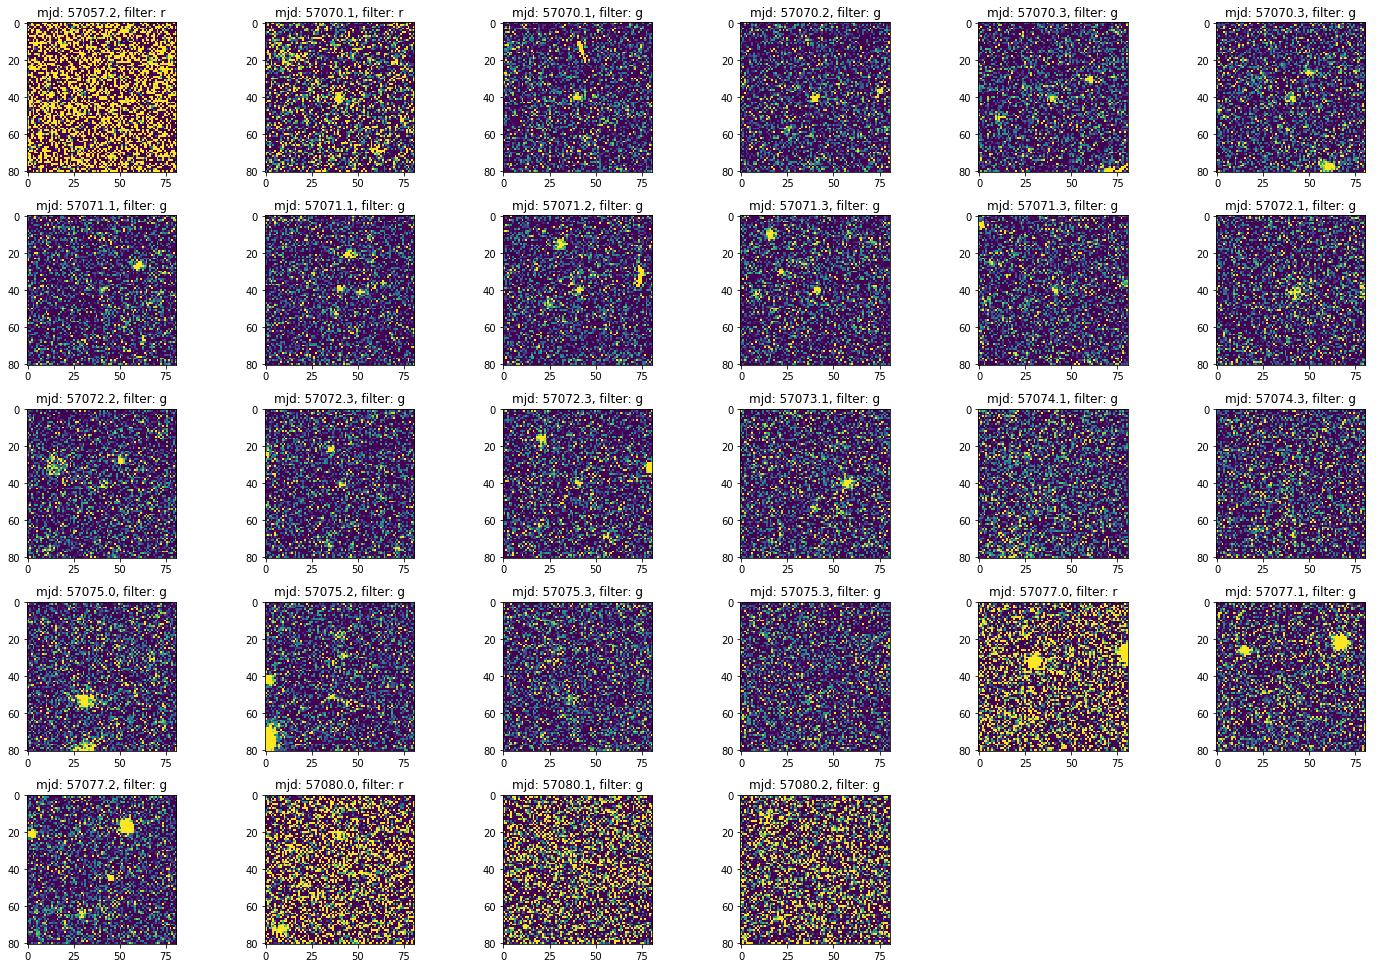

In [16]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(stamp_df)):
    fig.add_subplot(6, 6, i+1)
    plt.imshow(stamp_df['science_stamps'].iloc[i], vmax=15, vmin=0)
    plt.title('mjd: %.1f, filter: %s' % (stamp_df['stamp_mjd'].iloc[i], stamp_df['stamp_filter'].iloc[i]))
plt.tight_layout()

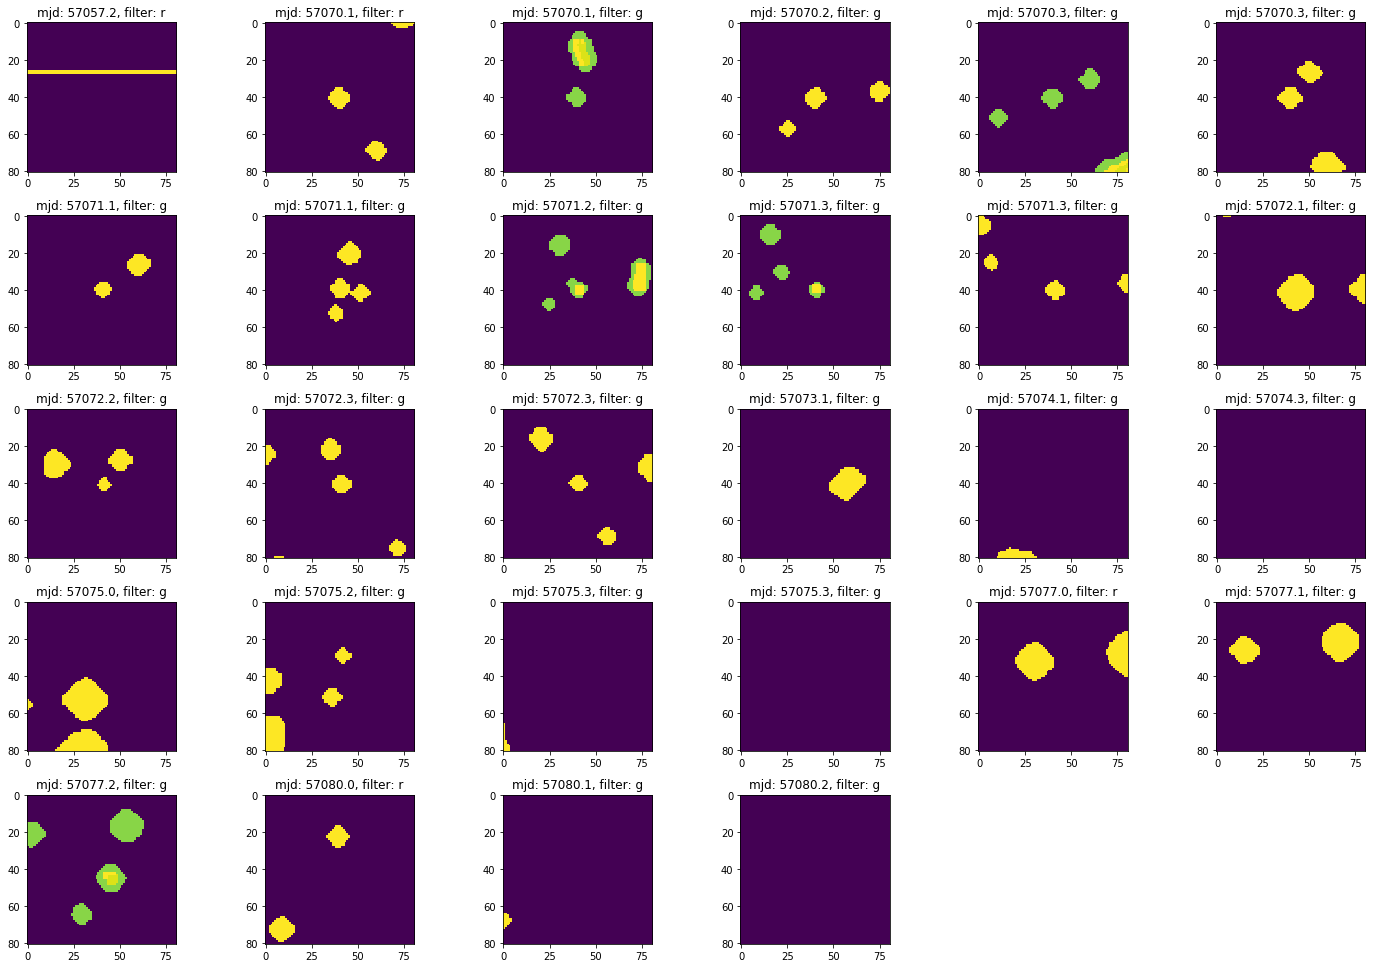

In [17]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(stamp_df)):
    fig.add_subplot(6, 6, i+1)
    plt.imshow(stamp_df['mask_stamps'].iloc[i])
    plt.title('mjd: %.1f, filter: %s' % (stamp_df['stamp_mjd'].iloc[i], stamp_df['stamp_filter'].iloc[i]))
plt.tight_layout()

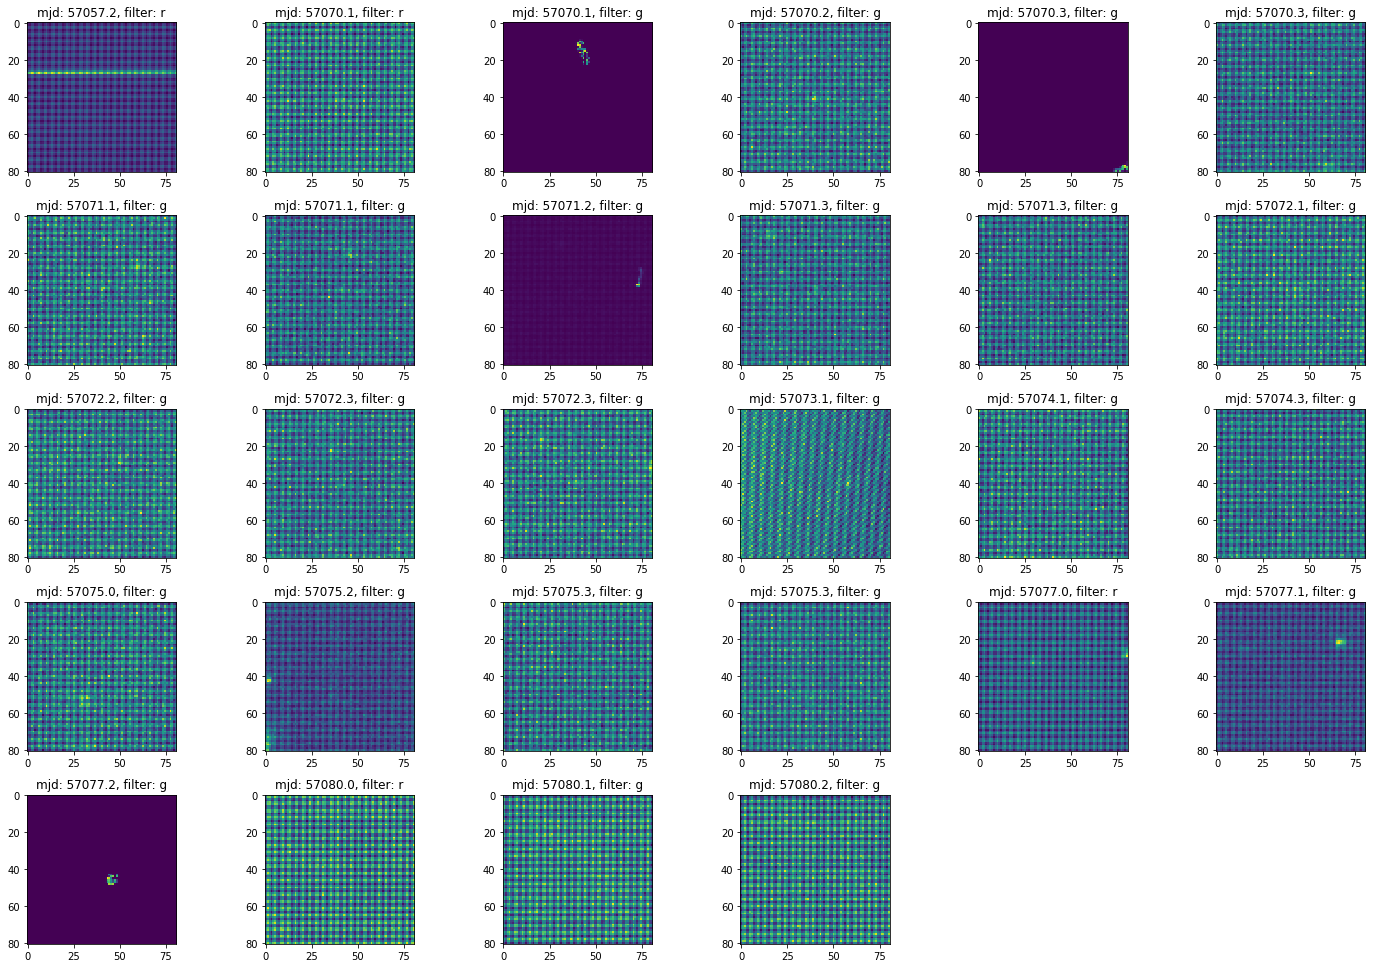

In [18]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(stamp_df)):
    fig.add_subplot(6, 6, i+1)
    plt.imshow(stamp_df['variance_stamps'].iloc[i])
    plt.title('mjd: %.1f, filter: %s' % (stamp_df['stamp_mjd'].iloc[i], stamp_df['stamp_filter'].iloc[i]))
plt.tight_layout()

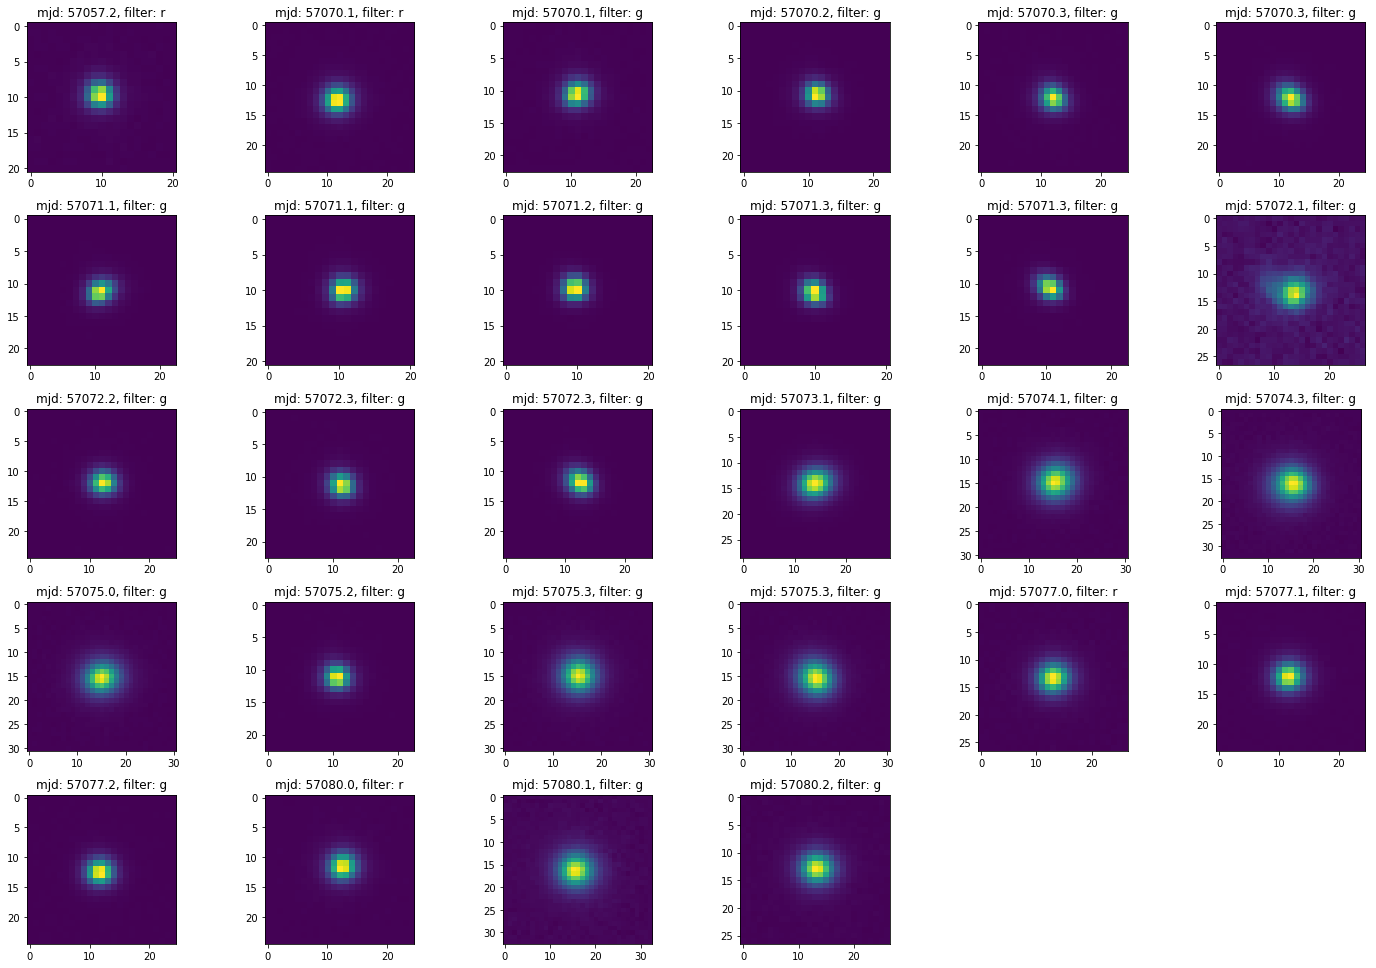

In [19]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(stamp_df)):
    fig.add_subplot(6, 6, i+1)
    plt.imshow(stamp_df['psf_stamps'].iloc[i])
    plt.title('mjd: %.1f, filter: %s' % (stamp_df['stamp_mjd'].iloc[i], stamp_df['stamp_filter'].iloc[i]))
plt.tight_layout()